In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read uniref90-10pm.db and select 1000 random rows with non-null embeddings
conn = sqlite3.connect('uniref90-10pm.db')
c = conn.cursor()
c.execute('SELECT * FROM uniref90 WHERE embedding IS NOT NULL AND LENGTH(sequence) < 1001 ORDER BY RANDOM() LIMIT 1000')
rows = c.fetchall()
conn.close()

In [3]:
from scipy.spatial.distance import euclidean
# check for None values in the embedding column
for row in rows:
    if row[2] is None:
        print('None value found in embedding column')
        break

# get the pairwise euclidean similarity from the embedding column, database structure is name, sequence, embedding
# make sure each embedding is a numpy array of shape (1024,)
embeddings = []

for row in rows:
    emb = np.frombuffer(row[2], dtype=np.float16)
    if emb.shape != (1024,):
        emb = np.frombuffer(row[2], dtype=np.float32)
    embeddings.append(emb)
# euclidean similarity formula is 0.5 / 0.5 + euclidean distance

# calculate the euclidean distance between all pairs of embeddings
similarity = []
distances = np.zeros((len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        distances[i, j] = euclidean(embeddings[i], embeddings[j])
        distances[j, i] = distances[i, j]
        similarity.append(0.5 / (0.5 + distances[i, j]))

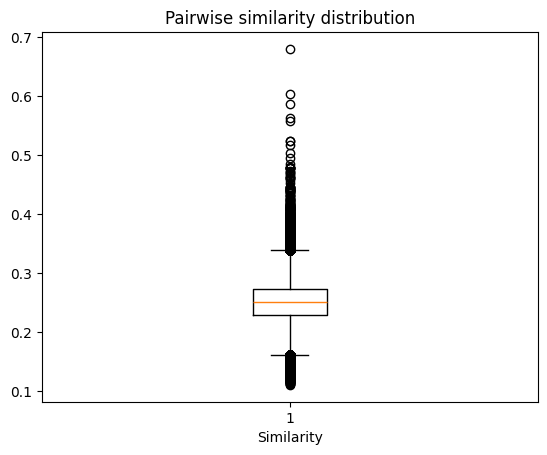

In [4]:
# plot the similarity distribution using a boxplot
plt.boxplot(similarity)
plt.xlabel('Similarity')
plt.title('Pairwise similarity distribution')
plt.show()

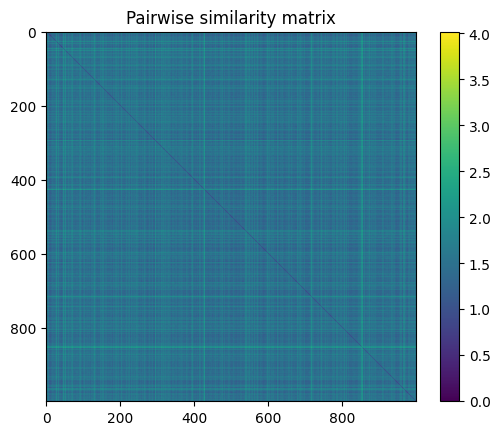

In [5]:
# plot the pairwise similarity matrix
plt.imshow(distances)
plt.colorbar()
plt.title('Pairwise similarity matrix')
plt.show()


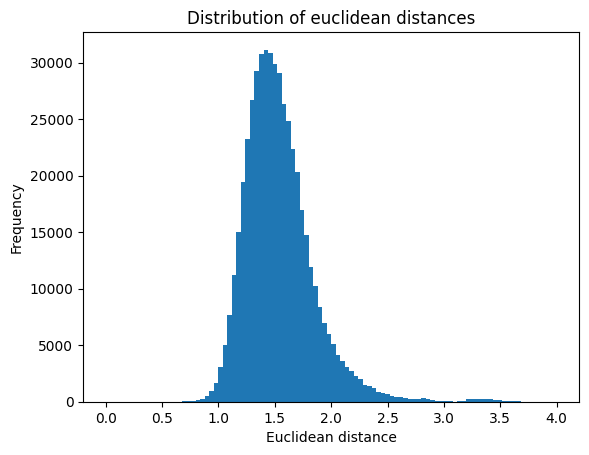

In [6]:
# plot distribution of euclidean distances
plt.hist(distances[np.triu_indices(1000, 1)], bins=100, range=(0, 4))
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')
plt.title('Distribution of euclidean distances')
plt.show()

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate the cosine similarity between all pairs of embeddings
similarity = []
cosine_similarities = cosine_similarity(embeddings)
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        similarity.append(cosine_similarities[i, j])

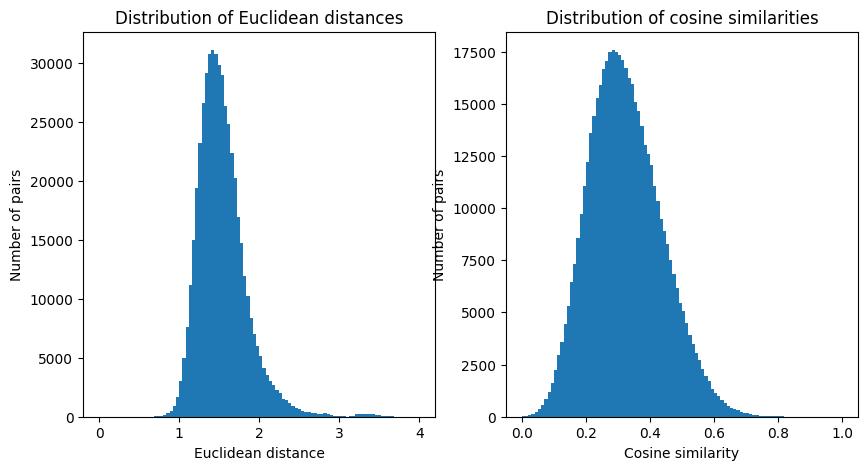

In [8]:
import matplotlib.pyplot as plt
#plot histograms of distances and similarities

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(distances[np.triu_indices(1000, 1)], bins=100, range=(0, 4))
plt.xlabel('Euclidean distance')
plt.ylabel('Number of pairs')
plt.title('Distribution of Euclidean distances')
plt.subplot(1, 2, 2)
plt.hist(similarity, bins=100, range=(0, 1))
plt.xlabel('Cosine similarity')
plt.ylabel('Number of pairs')
plt.title('Distribution of cosine similarities')
plt.show()